In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dataiku
from dataiku import pandasutils as pdu
import pandas as pd
import numpy as np
from __future__ import absolute_import

In [3]:
import keras
keras.__version__

/home/dataiku/dss/code-envs/python/dl-gpu/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.3.1'

# Using convnets with small datasets

This notebook contains the code sample found in Chapter 5, Section 2 of Deep Learning with Python. Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000 pictures for training, 1000 for validation, and finally 1000 for testing.

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. We will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be achieved. This will get us to a classification accuracy of 71%. At that point, our main issue will be overfitting. Then we will introduce data augmentation, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve our network to reach an accuracy of 82%.

In the next section, we will review two more essential techniques for applying deep learning to small datasets: doing feature extraction with a pre-trained network (this will get us to an accuracy of 90% to 93%), and fine-tuning a pre-trained network (this will get us to our final accuracy of 95%). Together, these three strategies -- training a small model from scratch, doing feature extracting using a pre-trained model, and fine-tuning a pre-trained model -- will constitute your future toolbox for tackling the problem of doing computer vision with small datasets.

## The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental characteristic of deep learning is that it is able to find interesting features in the training data on its own, without any need for manual feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can potentially suffice if the model is small and well-regularized and if the task is simple. Because convnets learn local, translation-invariant features, they are very data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature highly repurposable: you can take, say, an image classification or speech-to-text model trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.

In [4]:
import os, shutil

In [5]:
train_folder = dataiku.Folder("D0paMHZV").get_path()
test_folder = dataiku.Folder("6SbE0K9H").get_path()
validation_folder = dataiku.Folder("2XKNeAX1").get_path()

train_dogs_dir = os.path.join(train_folder, 'dogs')
train_cats_dir = os.path.join(train_folder, 'cats')

test_dogs_dir = os.path.join(validation_folder, 'dogs')
test_cats_dir = os.path.join(validation_folder, 'cats')

validation_dogs_dir = os.path.join(validation_folder, 'dogs')
validation_cats_dir = os.path.join(validation_folder, 'cats')

## Build the network

In [15]:
from keras import layers
from keras import models

# conv input_shape=(150, 150, 3), 32 --> maxpool --> conv 64 --> maxpool --> conv 128 --> maxpool --> conv 128 --> maxpool

# add Dense 512 first after conv part of the network
# classify with sigmoid

model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(150,150,3,)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.MaxPooling2D(2,2))

In [16]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)      

In [17]:
model.add(layers.Flatten())
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

In [18]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)      

In [19]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss="binary_crossentropy", metrics=['accuracy'])

# Data preprocessing

Steps for getting it into our network are roughly:

Read the picture files.

Decode the JPEG content to RBG grids of pixels.

Convert these into floating point tensors.

Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image processing helper tools, located at keras.preprocessing.image. In particular, it contains the class ImageDataGenerator which allows to quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we will use here.

## Use and understand a generator

In [22]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_folder,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_folder,
        target_size=(150,150),
        batch_size=20,
        class_mode="binary")

Found 2003 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's fit our model to the data using the generator. We do it using the fit_generator method, the equivalent of fit for data generators like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does. Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before declaring an epoch over. This is the role of the steps_per_epoch argument: after having drawn steps_per_epoch batches from the generator, i.e. after having run for steps_per_epoch gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using fit_generator, one may pass a validation_data argument, much like with the fit method. Importantly, this argument is allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as validation_data, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the validation_steps argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [23]:
# see fit_generator here https://keras.io/models/sequential/
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      validation_steps=50,
      epochs=5,
      validation_data=validation_generator)

Epoch 1/5
100/100 [==============================] - 118s 1s/step - loss: 0.6751 - accuracy: 0.5724 - val_loss: 0.6544 - val_accuracy: 0.6500
Epoch 2/5
100/100 [==============================] - 119s 1s/step - loss: 0.6265 - accuracy: 0.6420 - val_loss: 0.6204 - val_accuracy: 0.6200
Epoch 3/5
100/100 [==============================] - 128s 1s/step - loss: 0.5813 - accuracy: 0.6788 - val_loss: 0.4795 - val_accuracy: 0.6640
Epoch 4/5
100/100 [==============================] - 140s 1s/step - loss: 0.5530 - accuracy: 0.7201 - val_loss: 0.7068 - val_accuracy: 0.6850
Epoch 5/5
100/100 [==============================] - 133s 1s/step - loss: 0.5216 - accuracy: 0.7393 - val_loss: 0.6018 - val_accuracy: 0.6170


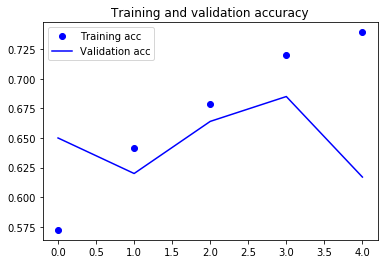

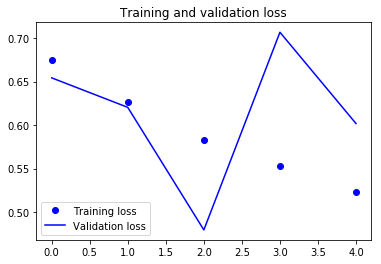

In [24]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data. Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our ImageDataGenerator instance. Let's get started with an example:

In [25]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures.

width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally.

shear_range is for randomly applying shearing transformations.

zoom_range is for randomly zooming inside pictures.

horizontal_flip is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal asymmetry (e.g. real-world pictures).

fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

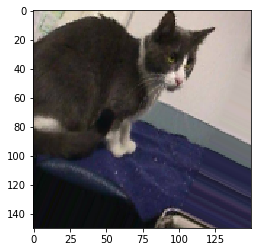

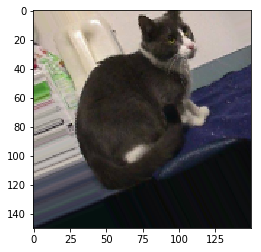

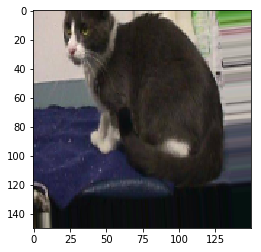

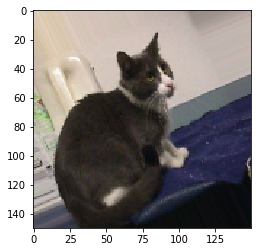

In [26]:
# This is module with image preprocessing utilities
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

## Build a model - We need to add a dropout !

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information, we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

## build same model but add dropout just before the Dense(512)

In [28]:
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3,3), activation="relu", input_shape=(150,150,3,)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128,(3,3),activation="relu"))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss="binary_crossentropy", metrics=['accuracy'])

In [29]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_folder,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_folder,
        target_size=(150,150),
        batch_size=20,
        class_mode="binary")

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      validation_steps=50,
      epochs=5,
      validation_data=validation_generator)

Found 2003 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/5
100/100 [==============================] - 63s 626ms/step - loss: 0.6929 - accuracy: 0.5043 - val_loss: 0.6708 - val_accuracy: 0.5870
Epoch 2/5
100/100 [==============================] - 64s 643ms/step - loss: 0.6794 - accuracy: 0.5693 - val_loss: 0.6943 - val_accuracy: 0.5770
Epoch 3/5
100/100 [==============================] - 64s 636ms/step - loss: 0.6739 - accuracy: 0.5648 - val_loss: 0.8156 - val_accuracy: 0.5230
Epoch 4/5
100/100 [==============================] - 58s 581ms/step - loss: 0.6611 - accuracy: 0.5835 - val_loss: 0.6052 - val_accuracy: 0.6100
Epoch 5/5
100/100 [==============================] - 54s 537ms/step - loss: 0.6585 - accuracy: 0.5930 - val_loss: 0.6236 - val_accuracy: 0.6660


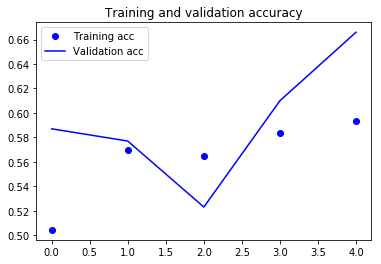

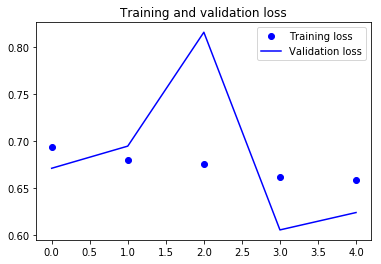

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two sections.

# Improvement of the network

Use all the technics we learnt to improve your network --> dropout + batchnorm

In [31]:
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Dense, BatchNormalization, Activation
from keras.layers import Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam

def build_model(input_shapes, n_classes=None):

    #### DEFINING INPUT AND BASE ARCHITECTURE
    # You need to modify the name and shape of the "image_input" 
    # according to the preprocessing and name of your 
    # initial feature.
    # This feature should to be preprocessed as an "Image", with a 
    # custom preprocessing.
    image_shape = (197, 197, 3)
    image_input_name = "name_of_your_image_input_preprocessed"

    image_input = Input(shape=image_shape, name=image_input_name)

    #### DEFINING THE ARCHITECTURE
    x = Conv2D(64, kernel_size=(11, 11), padding='same')(image_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)

    x = Conv2D(128, kernel_size=(7, 7), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)

    x = Conv2D(192, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)

    x = Conv2D(256, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3))(x)

    x = Flatten()(x)
    x = Dense(4096)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(4096)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(n_classes)(x)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)

    model = Model(inputs=image_input, outputs=x)

    return model

def compile_model(model):
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy"
    )
    return model

In [32]:
from keras.callbacks import ReduceLROnPlateau
from dataiku.doctor.deep_learning.shared_variables import get_variable

epochs = 10

# We monitor the same metric that is used to optimize the model
metric_to_monitor = "val_loss"
greater_is_better = False

reduce_lr_callback = ReduceLROnPlateau(monitor=metric_to_monitor,
                                       mode=("max" if greater_is_better else "min"),
                                       factor=0.2,
                                       patience=5)

base_callbacks = [reduce_lr_callback]

model.fit_generator(train_sequence,
                    epochs=epochs,
                    callbacks=base_callbacks,
                    shuffle=True)

NameError: name 'train_sequence' is not defined